In [5]:
# MIT License

# Copyright (c) 2023 Nathan Zorndorf

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.


import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.colors import LinearSegmentedColormap

In [34]:
class GamblersProblem:
    def __init__(self, p_h=0.5, win=100) -> None:
        self.p_h = p_h
        self.win = 100
        self.state = self.win/2 
        self.state_space = list(range(0,self.win+1))
        return
    
    def reset(self):
        self.state = self.win/2
        return
    
    def action_space(self, state):
        return list(range(1, min(state, self.win-state)+1)) # caps action space to [0-50] and thus resulting state space to [0,100]

    
    def random_choice(self):
        choices = [1, -1]
        probabilities = [self.p_h, 1 - self.p_h]
        result = np.random.choice(choices, p=probabilities)
        return result
    
    def step(self, state, action):
        """
        Run one timestep of the selfironment's dynamics.

        Args:
            state (int): An int storing the number of dollars available to bet
            action (int): The number of dollars to bet 

        Returns:
            (Tuple[int, float]): The new state of the system, and its correspondent reward
        """
        # if state == terminal state, return associated reward 
        if state == 0:
            reward = 0
            next_state = state 
        elif state == self.win:
            reward = 1  
            next_state = state 
        else:
            reward = 0 
            next_state = action * self.random_choice() # sample from bernoulli distribution with probability p_h 

        return next_state, reward 

    def get_dynamics(self, state, action):
        dynamics = [] # list of tuples 
        dynamics.append((self.p_h, int(state + action == self.win), self.state_value[state + action])) # if we win 
        dynamics.append((1-self.p_h, 0, self.state_value[state - action])) # if we lose 
        # dynamics.append((1-self.p_h, int(state - action == 0) * -1, self.state_value[state - action])) # if we lose 
        return dynamics
    
    def bellman_expectation(self, state, action, discount=1):
        expectation = 0
        for dynamics in self.get_dynamics(state, action):
            p, r, v = dynamics
            expectation += np.round(p * (r + discount * v), 10)
        return expectation

    def policy_evaluation(self, steps=1, in_place=False):
        '''
        Returns

        '''
        # initialize value function 
        self.state_value = np.zeros(self.win+1)
        # number of sweeps 
        for k in range(steps):
            # cache old values if not in place
            values = self.state_value if in_place else np.empty_like(self.state_value)
            # loop through states
            for state in self.state_space:
                # apply bellman expectation equation to each state-action pair 
                # since our policy is deterministic we only need to calculate the expectation for the action corresponding to the given state via the policy 
                value = self.bellman_expectation(state, self.policy[state])
                # assign value to value function array 
                values[state] = value # either in place or dual array 
            # set the new value table
            self.state_value = values
        return self.state_value
    
    def policy_improvement(self):
        '''
        Returns:
            (bool): True if policy no longer improves 
        '''
        # initialize convergence checker variable 
        policy_stable = True
        # iterate through state space 
        for state in self.state_space:
            # initialize variables 
            old_action = self.policy[state]
            best_action = old_action  # Initialize to the current policy action
            best_value = -float("inf")
            # find best action in terms of action-value 
            # V2
            action_values = np.zeros(len(self.action_space(state))+1) # initialize
            for action in self.action_space(state):
                action_values[action] = self.bellman_expectation(state, action)
            # how do you want to break ties of action values?
            best_action = np.argmax(action_values) # take first max 
            # define custom solution 
            best_actions = np.where(action_values == np.max(action_values))
            if len(best_actions) > 1:
                print(f's={state}, best_actions={best_actions}')
            best_action = np.max(best_actions)

            # V1
            # for action in self.action_space(state):
                # value = self.bellman_expectation(state, action)
                # if value > best_value:
                    # best_value = value 
                    # best_action = action

            # update policy with best action 
            self.policy[state] = best_action # save best action to policy 
            # check to see if policy has convered 
            policy_stable = policy_stable and (best_action == old_action)
        
        return policy_stable

    def policy_iteration(self):
        '''
        Returns: 
        '''
        # set up initial policy 
        self.policy = np.zeros(shape=len(self.state_space), dtype=np.int)
        # setup variables
        policy_stable = False
        i = 0
        # loop while policy has not converged
        while(policy_stable == False):
            # pitn counter 
            print(f'i={i}')
            # evaluate policy 
            value_function = self.policy_evaluation(steps=50, in_place=False) # updates self.state_value internally
            # improve policy 
            policy_stable = self.policy_improvement() # updates self.policy internally
            # plot 
            if i in [0, 1, 2, 3, 32, 100]:
                self.render(self.state_value, self.policy)
            # update counter variable 
            i += 1
            # if we haven't converged by now, exit 
            if i == 500:
                raise ValueError("The policy did not converge. Check your inputs or look for bugs.")
        # final plot 
        self.render(self.state_value, self.policy) # final render
        return 
    
    def value_iteration(self, theta=0.0001):
        '''
        Returns
            Tuple([np.array, np.array]): Tuple of (value_function, policy)
        '''
        # initialize value function 
        self.state_value = np.zeros(self.win+1)
        # while we haven't converged 
        while True: 
            delta = 0
            # find best action for each state 
            for state in self.state_space:
                # initialize array to save values
                action_values = np.zeros(self.win+1)
                # loop through each action available for this state 
                for action in self.action_space(state):
                    # calculate expectation for state action pair and update action_values array 
                    action_values[action] = self.bellman_expectation(state, action, discount=1)
                # taken the best action value across all actions for this state 
                best_value = np.max(action_values)
                # figure out if we've converged
                delta = max(delta, np.abs(best_value - self.state_value[state]))
                # save best value to value function  for this state 
                self.state_value[state] = best_value
            # check convergence condition 
            if delta < theta:
                break
        
        # Create a deterministic policy using the optimal value function
        self.policy = np.zeros(shape=len(self.state_space), dtype=np.int)
        # discover best action for each state
        for state in range(1, self.win):
            # One step lookahead to find the best action for this state
            A = np.zeros(self.win+1)
            # find action that corresponds with highest value (bellman expectation)
            for action in self.action_space(state):
                A[action] = self.bellman_expectation(state, action, discount=1)
            # Always take the best action
            self.policy[state] = np.argmax(A)

        # return value function and policy 
        return self.state_value, self.policy

    def render(self, values, policy):
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        # plot values
        ax[0].set_ylabel("Values\nEstimates", rotation=0, labelpad=20)
        ax[0].set_xlabel("Capital")
        ax[0].plot(values)

        # plot policy
        ax[1].bar(range(len(policy)), policy, color="black")
        ax[1].set_ylabel("Final\nPolicy\n(stake)", rotation=0, labelpad=20)
        ax[1].set_xlabel("Capital")
        plt.show()
        return fig, ax

    


    

i=0


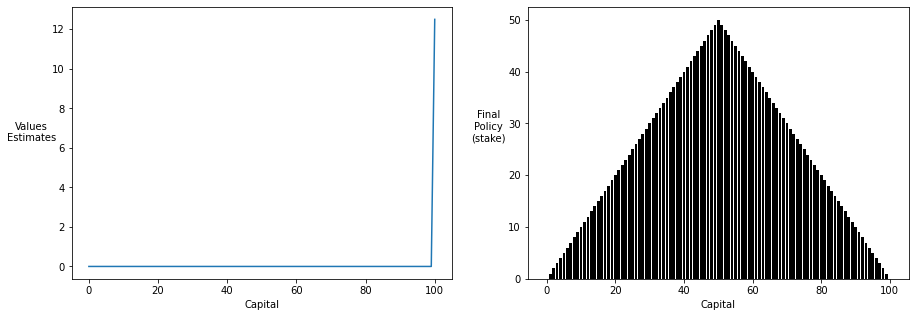

i=1


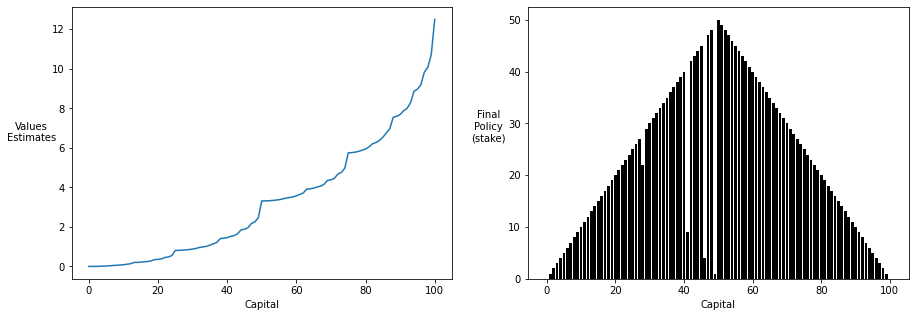

i=2


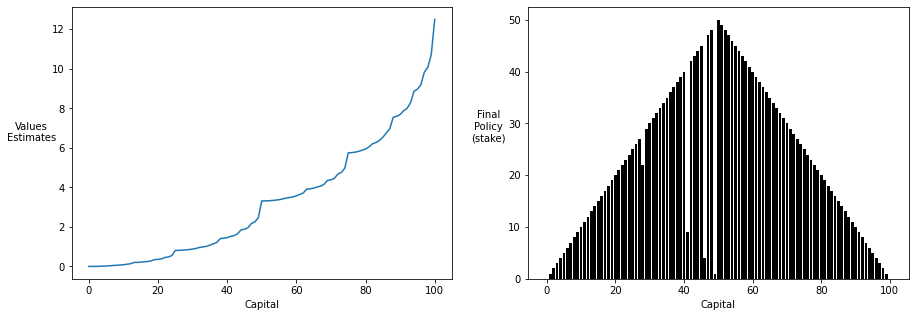

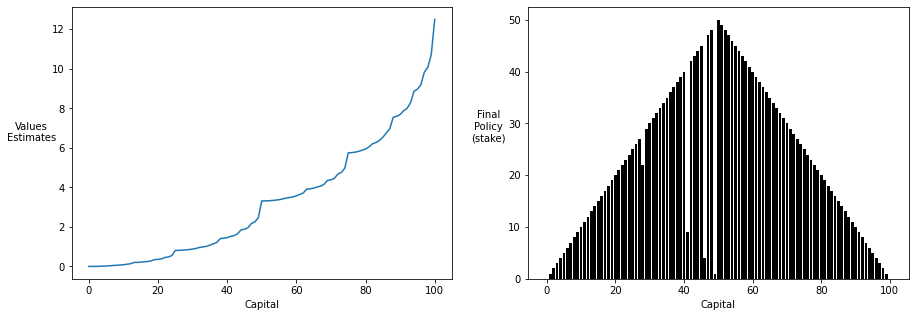

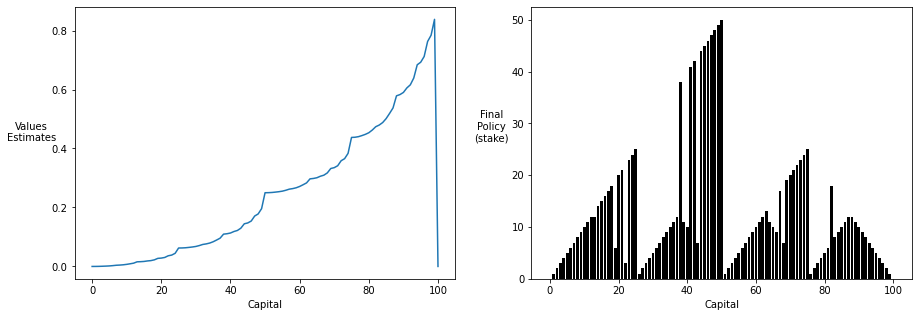

(<Figure size 1080x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffd0f322f70>,
       dtype=object))

In [35]:
# parameters
WIN = 100 
P_H = 0.25

# initialize environment
env = GamblersProblem(p_h=P_H)

# perform policy iteration
env.policy_iteration()

# perform value iteration
value_function, policy = env.value_iteration()
env.render(value_function, policy)
